# How to Build a Spam Filter with Naive Bayes Classification

## 1. Objective

We aim to develop a classifier that is able to determine whether a certain text is spam or not (sometimes referred to as "ham" in contrast).
To train and test our algorithm we use a set of comments originally posted below a YouTube video.
The task at hand is text classification, hence, **Multinomial Naive Bayes** is likely a good choice.

In this exercise you will learn the following:
- Data exploration and text preprocessing using `CountVectorizer`.
- Splitting data into training and test sets using `train_test_split`.
- Training a Naive Bayes classifier with `sklearn.naive_bayes`. 
- Make predictions and evaluate the model performance with `sklearn.metrics`.

### 1.1. Prerequisites

Make sure to have the relevant dependencies installed in your environment, namely **pandas**, **scikit-learn** and **seaborn**.
You can use e.g. Anaconda Navigator or install the with the following command:

``pip install pandas scikit-learn seaborn``

### 1.2. Dataset

We use data from UC Irvine Machine Learning Repository which holds popular datasets often used for research and education purposes.\
In this case, we focus on the **YouTube Spam Collection** dataset authored by T.C. Alberto and J.V. Lochter (__[https://archive.ics.uci.edu/dataset/380/youtube+spam+collection](https://archive.ics.uci.edu/dataset/380/youtube+spam+collection)__).

The collection holds five datasets composed by **1,956 text comments extracted from YouTube music videos** that were popular around 2017.\
The table below lists the datasets, the YouTube video ID, the amount of samples in each class and the total number of samples per dataset.

The collection is composed by one CSV file per dataset, where each line has the following attributes:

| Dataset      | YouTube ID   | # Spam | # Ham | # Total |
| :----------- | :----------: | :----: | :---: | :-----: |
| Psy          | 9bZkp7q19f0  | 175    | 175   | 350     |
| KatyPerry    | CevxZvSJLk8  | 175    | 175   | 350     |
| LMFAO        | KQ6zr6kCPj8  | 236    | 202   | 438     |
| Eminem       | uelHwf8o7_U  | 245    | 203   | 448     |
| Shakira      | pRpeEdMmmQ0  | 174    | 196   | 370     |

Each dataset holds the comments in the following format:
1. `COMMENT_ID`: the unique identifier of a comment (e.g. z12oglnpoq3gjh4om04cfdlbgp2uepyytpw0k)
2. `AUTHOR`: the name of the author (e.g. Francisco Nora)
3. `DATE`: the date when the comment was originally posted (format: YYYY-MM-DDThh\:mm\:ss.f)
4. `CONTENT`: text snippet of the original comment
5. `CLASS`: the _binary_ classification whether the comment has been labelled as spam (`1`) or ham / no spam (`0`)



### 1.3. Import Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## 2. Prepare Data

In the following implementation we will focus on one dataset of the collection only (see table above for details).

### 2.1. Quick Exploratory Data Analysis

In [7]:
comments = pd.read_csv('data/youtube_spam_collection/Youtube02-KatyPerry.csv', sep=',')

In [8]:
comments.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,z12pgdhovmrktzm3i23es5d5junftft3f,lekanaVEVO1,2014-07-22T15:27:50,i love this so much. AND also I Generate Free ...,1
1,z13yx345uxepetggz04ci5rjcxeohzlrtf4,Pyunghee,2014-07-27T01:57:16,http://www.billboard.com/articles/columns/pop-...,1
2,z12lsjvi3wa5x1vwh04cibeaqnzrevxajw00k,Erica Ross,2014-07-27T02:51:43,Hey guys! Please join me in my fight to help a...,1
3,z13jcjuovxbwfr0ge04cev2ipsjdfdurwck,Aviel Haimov,2014-08-01T12:27:48,http://psnboss.com/?ref=2tGgp3pV6L this is the...,1
4,z13qybua2yfydzxzj04cgfpqdt2syfx53ms0k,John Bello,2014-08-01T21:04:03,Hey everyone. Watch this trailer!!!!!!!! http...,1


In [9]:
comments.shape

(350, 5)

In [10]:
comments['CLASS'].value_counts()

CLASS
1    175
0    175
Name: count, dtype: int64

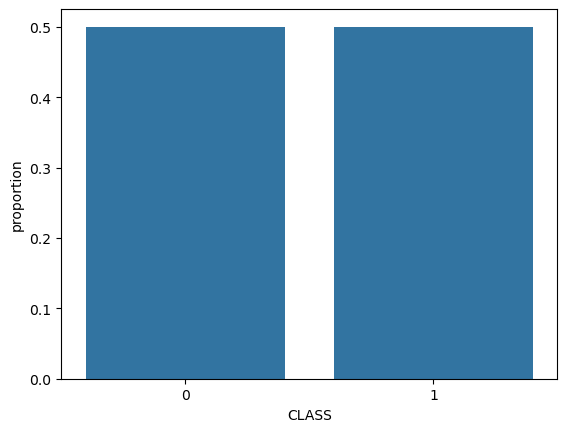

In [11]:
sns.barplot(data = comments['CLASS'].value_counts(normalize=True))
plt.show()

We can conclude that we have a well-balanced dataset with 50\% spam and 50\% ham data.

### 2.2. Preprocess the Data

Turn our data into **bag-of-words** representation using `CountVectorizer`.

In [88]:
# Initialize the CountVectorizer to transform text into a bag-of-words model
vectorizer = CountVectorizer(stop_words='english')

# Convert the messages into numeric form
X = vectorizer.fit_transform(comments['CONTENT'])

y = comments['CLASS']

Let us look at some random features used in our Vectorizer:

In [90]:
feature_array = vectorizer.get_feature_names_out()
feature_array[580:599]

array(['files', 'filmes', 'filming', 'fils', 'final', 'finding', 'finish',
       'firework', 'fit', 'flat', 'floooooooooooooooooooop', 'floor',
       'flowers', 'fly', 'folks', 'follow', 'folly', 'fool', 'foolish'],
      dtype=object)

In [91]:
comments[comments['CLASS'] == 0].head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
35,z121tz2zhzjgercem23yttsqvnuijljql04,Daniel Korp,2014-08-24T17:17:17,"katy perry does remind me of a tiger,like as i...",0
36,z13hyv0ixuavuliyt04cix1j5t3qgpggce4,Paul Hannam,2014-08-25T05:37:22,In what South American jungle or any jungle fo...,0
39,z13cyh3gowyyxlotr23vsplhbt23hbmwy04,Angie Sivrikozi,2014-08-27T21:12:48,"Its a good song and i like her video clip, bec...",0
42,z13cwrzyolf1zh4v023ctteams25hldf5,Zain Hassan,2014-08-29T19:00:20,Thanks to this video we know that Nokia phones...,0
46,z135drnwswvsgvkyq04cfjh4xpb3cn2hugg,Sam Klein,2014-08-31T03:52:29,"She named the tiger Kitty Purry No, seriously...",0


In [40]:
comments[comments['CLASS'] == 1].head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,z12pgdhovmrktzm3i23es5d5junftft3f,lekanaVEVO1,2014-07-22T15:27:50,i love this so much. AND also I Generate Free ...,1
1,z13yx345uxepetggz04ci5rjcxeohzlrtf4,Pyunghee,2014-07-27T01:57:16,http://www.billboard.com/articles/columns/pop-...,1
2,z12lsjvi3wa5x1vwh04cibeaqnzrevxajw00k,Erica Ross,2014-07-27T02:51:43,Hey guys! Please join me in my fight to help a...,1
3,z13jcjuovxbwfr0ge04cev2ipsjdfdurwck,Aviel Haimov,2014-08-01T12:27:48,http://psnboss.com/?ref=2tGgp3pV6L this is the...,1
4,z13qybua2yfydzxzj04cgfpqdt2syfx53ms0k,John Bello,2014-08-01T21:04:03,Hey everyone. Watch this trailer!!!!!!!! http...,1


In [93]:
dense_X = X.todense()
dense_X

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

### 2.3. Split into Training and Test Data

Let us split the dataset into two datasets used for training (80\%) and testing (20\%) purposes. The latter will be used to evaluate our classifier.\
The original dataset is rather balanced already and we wish to keep the same balance in the newly generated datasets.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [16]:
# Percentage class distribution in test data
y_test.value_counts(normalize=True)*100

CLASS
0    52.857143
1    47.142857
Name: proportion, dtype: float64

In [17]:
# Percentage class distribution in training data
y_train.value_counts(normalize=True)*100

CLASS
1    50.714286
0    49.285714
Name: proportion, dtype: float64

## 3. Train a Naive Bayes Classifier

Remember that we can use a **Multinomial Naive Bayes** classifier for text data.

In [18]:
# Initialize Naive Bayes with Laplace smoothing (alpha=1.0)
model = MultinomialNB(alpha=1.0)

model.fit(X_train, y_train)

MultinomialNB()

## 4. Make predictions and evaluate model performance

### 4.1. Make predictions

In [19]:
# Make predictions on the test data
y_pred = model.predict(X_test)

### 4.2. Evaluate performance

The **accuracy** metric shows how many predictions were correct out of the total predictions. 
A high accuracy indicates that the model is correctly distinguishing between spam and ham messages.

Further metrics to consider are:
- **Precision**: The ratio of true positive predictions (correctly predicted spam) to all predicted positives.
- **Recall**: The ratio of true positives to all actual positives (how well the model identifies spam).
- **F1-Score**: The harmonic mean of precision and recall, providing a balanced evaluation of the model’s performance.

In [20]:
# Print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.1f}%")

# Generate classification report
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

print(report_df)

Accuracy: 88.6%
              precision    recall  f1-score    support
0              0.837209  0.972973  0.900000  37.000000
1              0.962963  0.787879  0.866667  33.000000
accuracy       0.885714  0.885714  0.885714   0.885714
macro avg      0.900086  0.880426  0.883333  70.000000
weighted avg   0.896493  0.885714  0.884286  70.000000


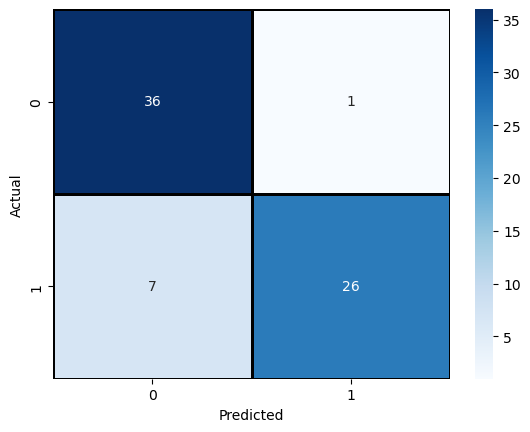

In [21]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=1, linecolor='black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()